In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

True
cuda


In [3]:
N_SAMPLES = 1000
RANDOM_STATE = 42
X, y = make_moons(n_samples=N_SAMPLES, random_state=RANDOM_STATE, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = torch.from_numpy(X_train).float().to("cuda")
X_test = torch.from_numpy(X_test).float().to("cuda")
y_train = torch.from_numpy(y_train).float().to("cuda")
y_test = torch.from_numpy(y_test).float().to("cuda")


y_train.shape


torch.Size([800])

In [4]:
X_train, y_train

(tensor([[ 2.2360,  0.4705],
         [-1.3513,  0.4264],
         [-0.2783,  1.2589],
         ...,
         [-0.9431,  0.3833],
         [ 1.2209,  0.2535],
         [ 1.9510,  0.1674]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
         0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,

In [5]:
table = {"X1": X[:, 0], "X2": X[:, 1], "label": y}
pd.DataFrame(table)

,X1,X2,label
0,-0.171863,0.596249,1
1,1.253283,-0.265414,1
2,0.723224,0.231943,1
3,-0.065198,-0.655194,1
4,-0.799493,0.552935,0
...,...,...,...
995,0.861014,0.343843,0
996,-0.229425,0.754849,0
997,1.770957,-0.509436,1
998,-1.061772,0.006786,0


In [6]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

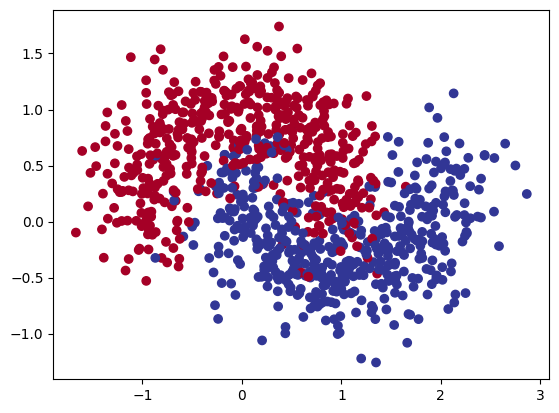

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [8]:
class MoonModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_layers):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=output_features),
            
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


# Instantiate the model with more hidden layers or neurons if needed
model_0 = MoonModelV0(input_features=2, output_features=1, hidden_layers=10).to(device)

In [9]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [11]:
epochs = 10000

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    Y_pred_probs = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=Y_pred_probs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.71659 | Train Acc: 25.62% | Test Loss: 0.71048 | Test Acc: 28.00%
Epoch: 10 | Train Loss: 0.68059 | Train Acc: 80.62% | Test Loss: 0.67763 | Test Acc: 84.00%
Epoch: 20 | Train Loss: 0.64846 | Train Acc: 83.38% | Test Loss: 0.64766 | Test Acc: 81.00%
Epoch: 30 | Train Loss: 0.61172 | Train Acc: 82.75% | Test Loss: 0.61297 | Test Acc: 80.00%
Epoch: 40 | Train Loss: 0.56738 | Train Acc: 82.12% | Test Loss: 0.57140 | Test Acc: 79.00%
Epoch: 50 | Train Loss: 0.51789 | Train Acc: 82.00% | Test Loss: 0.52597 | Test Acc: 79.00%
Epoch: 60 | Train Loss: 0.47073 | Train Acc: 82.38% | Test Loss: 0.48352 | Test Acc: 79.50%
Epoch: 70 | Train Loss: 0.43261 | Train Acc: 83.00% | Test Loss: 0.44952 | Test Acc: 79.50%
Epoch: 80 | Train Loss: 0.40534 | Train Acc: 83.00% | Test Loss: 0.42462 | Test Acc: 79.50%
Epoch: 90 | Train Loss: 0.38650 | Train Acc: 83.50% | Test Loss: 0.40672 | Test Acc: 79.50%
Epoch: 100 | Train Loss: 0.37319 | Train Acc: 84.12% | Test Loss: 0.39339 | Test 

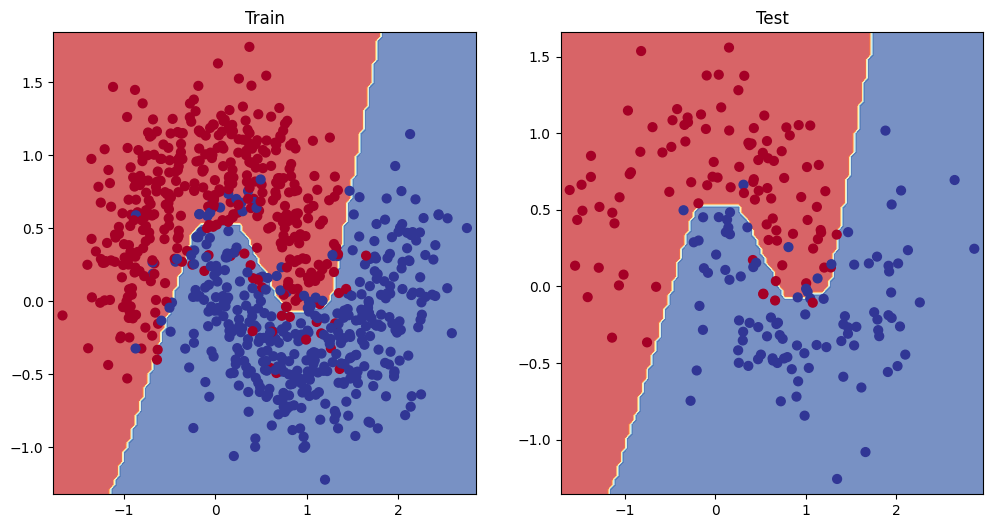

In [12]:
from helper_functions import plot_decision_boundary


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)  # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)  # model_3 = has non-linearity

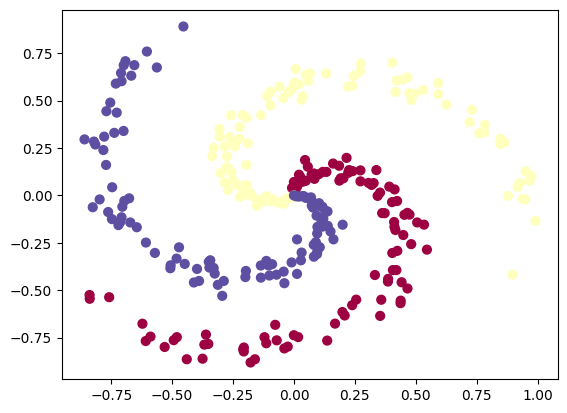

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np

N = 100  # number of points per class
D = 2  # dimensionality
K = 3  # number of classes
X = np.zeros((N * K, D))  # data matrix (each row = single example)
y = np.zeros(N * K, dtype="uint8") # class labels
for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)  # radius
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [39]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


X_blob_train = torch.from_numpy(X_blob_train).type(torch.FloatTensor).to(device=device)
X_blob_test = torch.from_numpy(X_blob_test).type(torch.FloatTensor).to(device=device)
y_blob_train = torch.from_numpy(y_blob_train).type(torch.LongTensor).to(device=device)
y_blob_test = torch.from_numpy(y_blob_test).type(torch.LongTensor).to(device=device)


print(f"Device of X_blob_train: {X_blob_train.device}")
print(f"Device of X_blob_test: {X_blob_test.device}")
print(f"Device of y_blob_train: {y_blob_train.device}")
print(f"Device of y_blob_test: {y_blob_test.device}")


print(f"X_blob_train dtype: {X_blob_train.dtype}")
print(f"X_blob_test dtype: {X_blob_test.dtype}")
print(f"y_blob_train dtype: {y_blob_train.dtype}")
print(f"y_blob_test dtype: {y_blob_test.dtype}")

Device of X_blob_train: cuda:0
Device of X_blob_test: cuda:0
Device of y_blob_train: cuda:0
Device of y_blob_test: cuda:0
X_blob_train dtype: torch.float32
X_blob_test dtype: torch.float32
y_blob_train dtype: torch.int64
y_blob_test dtype: torch.int64


In [66]:
class SpiralModelv0(nn.Module):
    def __init__(self, input_features, output_features, hidden_layers):
        super().__init__()

        self.stacked_layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=output_features),
            # nn.ReLU(),
            # nn.Linear(in_features=hidden_layers, out_features=output_features),
        )

    def forward(self, x:torch.Tensor):
        return self.stacked_layer(x)


model_1 = SpiralModelv0(input_features=2, output_features=4, hidden_layers=64).to(device)


model_1

SpiralModelv0(
  (stacked_layer): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [67]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [68]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [69]:
epochs = 10000

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_blob_train).to(device)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)
        
        if epoch % 10 == 0 :
            print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")
    

Epoch: 0 | Train Loss: 1.36799 | Train Acc: 34.58% | Test Loss: 1.37599 | Test Acc: 26.67%
Epoch: 10 | Train Loss: 1.35649 | Train Acc: 35.00% | Test Loss: 1.36463 | Test Acc: 26.67%
Epoch: 20 | Train Loss: 1.34594 | Train Acc: 35.00% | Test Loss: 1.35415 | Test Acc: 26.67%
Epoch: 30 | Train Loss: 1.33614 | Train Acc: 35.00% | Test Loss: 1.34442 | Test Acc: 26.67%
Epoch: 40 | Train Loss: 1.32698 | Train Acc: 35.00% | Test Loss: 1.33537 | Test Acc: 26.67%
Epoch: 50 | Train Loss: 1.31846 | Train Acc: 35.00% | Test Loss: 1.32697 | Test Acc: 26.67%
Epoch: 60 | Train Loss: 1.31053 | Train Acc: 35.00% | Test Loss: 1.31912 | Test Acc: 26.67%
Epoch: 70 | Train Loss: 1.30306 | Train Acc: 35.00% | Test Loss: 1.31172 | Test Acc: 26.67%
Epoch: 80 | Train Loss: 1.29596 | Train Acc: 35.00% | Test Loss: 1.30470 | Test Acc: 26.67%
Epoch: 90 | Train Loss: 1.28923 | Train Acc: 35.00% | Test Loss: 1.29803 | Test Acc: 26.67%
Epoch: 100 | Train Loss: 1.28284 | Train Acc: 35.00% | Test Loss: 1.29171 | Test 